# **Hyperparameter Tuning**

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pd.read_csv("../data/heart_selected_super.csv")  # Use your selected features
X = df.drop(columns=["target"])
y = df["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features if needed (SVM benefits from scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Optimize Model Hyperparameters
Use GridSearchCV & RandomizedSearchCV

In [16]:
models_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=2000, solver="liblinear"),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "penalty": ["l1", "l2"],
            "solver": ["liblinear"]
        },
        "use_scaled": False
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 3, 5, 7, 10],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        },
        "use_scaled": False
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200, 500],
            "max_depth": [None, 3, 5, 7],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        },
        "use_scaled": False
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10, 100],
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"]
        },
        "use_scaled": True
    }
}

In [17]:
tuned_results = []

for name, mp in models_params.items():
    print(f"Running GridSearchCV for {name}...")
    model = mp["model"]
    params = mp["params"]
    X_tr = X_train_scaled if mp["use_scaled"] else X_train
    X_te = X_test_scaled if mp["use_scaled"] else X_test
    
    grid = GridSearchCV(model, params, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_tr, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_te)
    y_prob = best_model.predict_proba(X_te)
    
    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    auc_score = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), y_prob,
                              multi_class="ovr", average="weighted")
    
    tuned_results.append([name, acc, prec, rec, f1, auc_score, grid.best_params_])
    print(f"Best params for {name}: {grid.best_params_}\n")

Running GridSearchCV for Logistic Regression...
Best params for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

Running GridSearchCV for Decision Tree...
Best params for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Running GridSearchCV for Random Forest...
Best params for Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}

Running GridSearchCV for SVM...
Best params for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}



# 2. Compare
Optimized Models with Baseline Performance

In [18]:
results_df = pd.DataFrame(tuned_results, columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1", "AUC", "Best_Params"
])
display(results_df)

,Model,Accuracy,Precision,Recall,F1,AUC,Best_Params
0,Logistic Regression,0.614035,0.502584,0.614035,0.538942,0.842681,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline..."
1,Decision Tree,0.578947,0.467568,0.578947,0.514062,0.731056,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s..."
2,Random Forest,0.649123,0.558897,0.649123,0.589695,0.803519,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s..."
3,SVM,0.631579,0.584969,0.631579,0.568696,0.764837,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}"


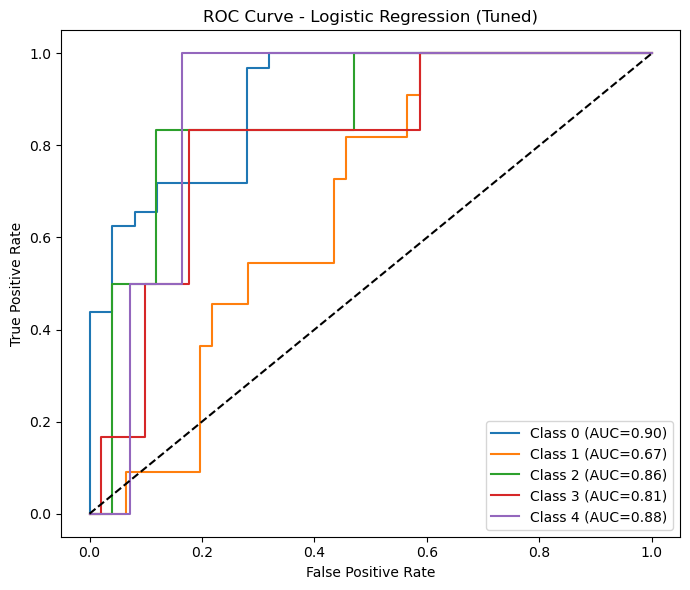

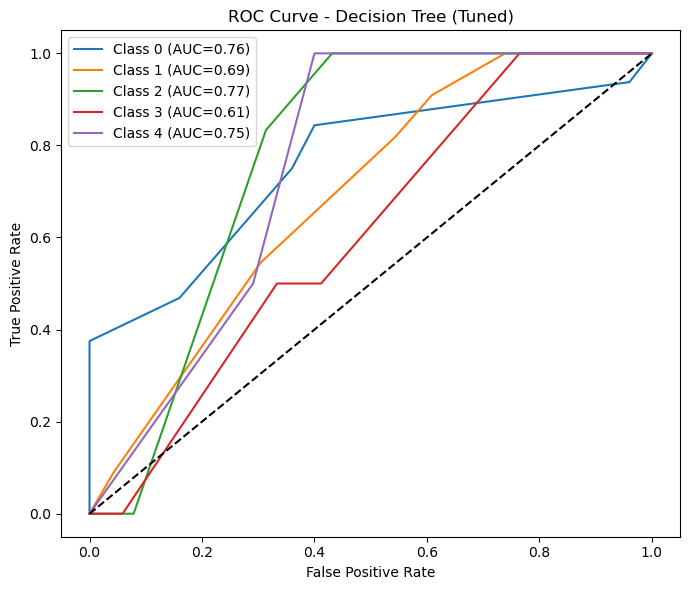

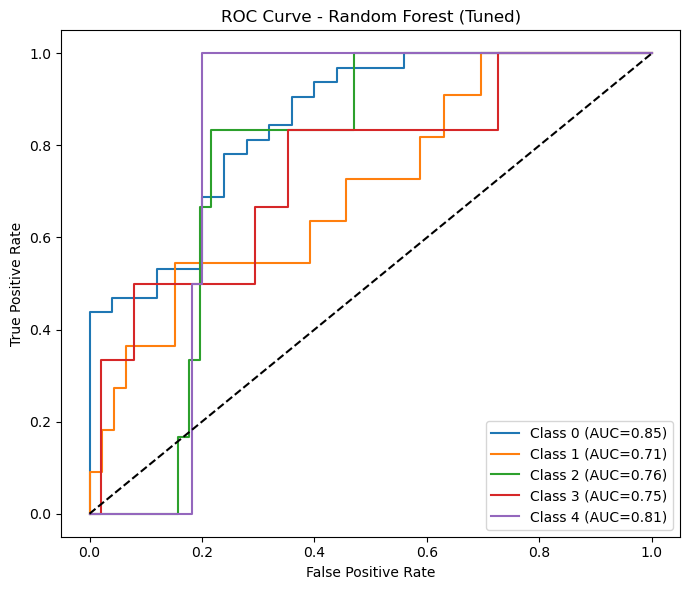

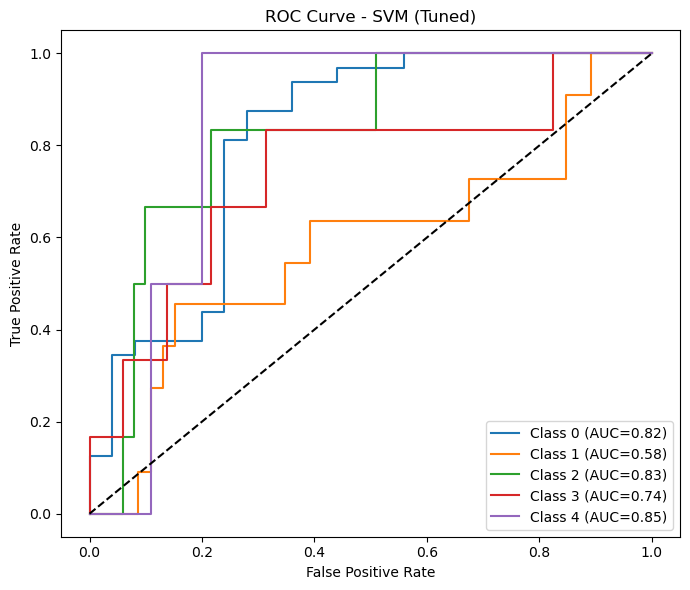

In [19]:
# Plot ROC curves for tuned models
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

for name, mp in models_params.items():
    best_model = GridSearchCV(mp["model"], mp["params"], cv=5, scoring="accuracy", n_jobs=-1)
    X_tr = X_train_scaled if mp["use_scaled"] else X_train
    X_te = X_test_scaled if mp["use_scaled"] else X_test
    best_model.fit(X_tr, y_train)
    
    y_prob = best_model.predict_proba(X_te)
    
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f"Class {cls} (AUC={auc(fpr, tpr):.2f})")
    
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name} (Tuned)")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Pipeline

In [20]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Use the tuned hyperparameters for Random Forest
rf_best = RandomForestClassifier(
    n_estimators=500,
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=42
)

# Pipeline with scaling + model (scaling optional for RF, but keeps consistency)
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # optional for RF
    ("classifier", rf_best)
])

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=5, min_samples_split=10,
                                        n_estimators=500, random_state=42))])

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
    "F1": f1_score(y_test, y_pred, average="weighted", zero_division=0),
    "AUC": roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), y_prob,
                         multi_class="ovr", average="weighted")
}

# Print metrics
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Accuracy: 0.6491
Precision: 0.5589
Recall: 0.6491
F1: 0.5897
AUC: 0.8035


In [22]:
# Export pipeline
joblib.dump(pipeline, "../models/final_model.pkl")
print("Pipeline saved as final_model.pkl")

# Save metrics to a text file
with open("../results/evaluation_metrics.txt", "w") as f:
    f.write("Evaluation Metrics for Random Forest Pipeline\n")
    f.write("="*50 + "\n")
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.4f}\n")

print("Evaluation metrics saved to evaluation_metrics.txt")


Pipeline saved as final_model.pkl
Evaluation metrics saved to evaluation_metrics.txt
